In [256]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable


from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra

pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/

In [257]:
%matplotlib notebook

In [7]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

In [10]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


In [38]:
def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, stimperiod * fr * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo

# Select data set

In [8]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']

In [13]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [80]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
traces = h5py.File(extracted_traces_fpath)
print traces.keys()
print traces[traces.keys()[0]].keys()


FOV: FOV1_zoom4p0x, run: retino_run1
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
[u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']


# Set output dir

In [116]:
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get stimulus info

In [46]:
# Get cycle starts:
curr_cond = 'right'
stiminfo['right']

for trial in trials_by_cond[curr_cond]:
    
    print traces['File%03d' % trial]['processed'].shape

(108, 4125)
(108, 4125)
(108, 4125)


In [47]:
traces['File%03d' % trial]['processed'][rid, :]

array([ 9.59420287,  9.96958087,  8.60878114, ...,  2.83364615,
        3.57679778,  7.05371019])

In [219]:
def get_parsed_cycles(rid, traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []
        for trial in trial_nums:

            roi_trace = traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces = np.zeros((nparsed_cycles, fr_per_cycle))
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]

            roi_cycles.append(ptraces)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = [s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

# Look at 1 ROI first

In [313]:
rid = 27

roi_traces = np.array([traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[c1]])
print roi_traces.shape

(3, 4125)


<IPython.core.display.Javascript object>


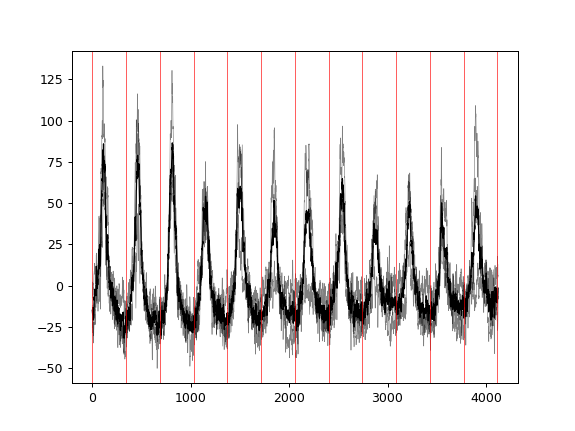

In [314]:

pl.figure()
for tr in np.arange(0, roi_traces.shape[0]):
    pl.plot(roi_traces[tr,:], 'k', lw=0.5, alpha=0.5)
    
pl.plot(roi_traces.mean(axis=0), 'k', lw=1, alpha=1)
    
for cyc in stiminfo[c1]['cycle_start_ixs']:
    pl.axvline(x=cyc, color='r', lw=0.5)

# Get average N cycles

In [315]:
chunksize = 3
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, traces, stiminfo, chunksize=chunksize)
parsed_cycle_ixs

{u'bottom': [0, 343, 686, 1029, 1372],
 u'left': [0, 343, 686, 1029, 1372],
 u'right': [0, 343, 686, 1029, 1372],
 u'top': [0, 343, 686, 1029, 1372]}

<IPython.core.display.Javascript object>


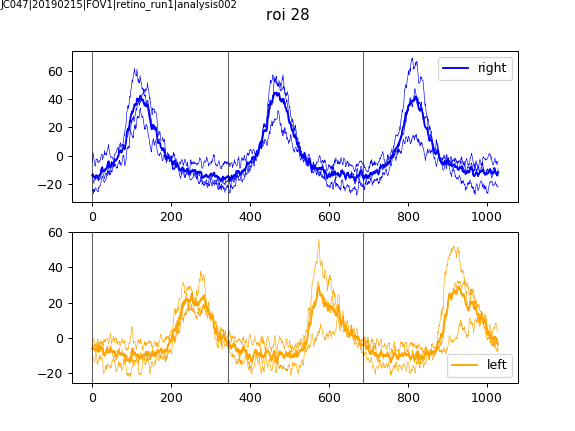

In [316]:
c1 = 'right'
c2 = 'left'
c1_color = 'blue'
c2_color = 'orange'

fig, axes = pl.subplots(2,1)

# nreps, ncycles, nframes_per = parsed_traces[curr_cond].shape

ax = axes[0]
for rep in np.arange(stiminfo[c1]['n_reps']):
    ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)
    
ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1)
ax.legend()
for cyc in parsed_cycle_ixs[c1][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)
    
ax = axes[1]
for rep in np.arange(stiminfo[c2]['n_reps']):
    ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
ax.legend()

for cyc in parsed_cycle_ixs[c2][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)
    
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)

figname = 'averaged_%i_cycle_by_run_roi%05d_%s_%s' % (chunksize, int(rid+1), c1, c2)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))


In [442]:
nstds_above_baseline = 1.5
window_nsecs = 01
windowsize = int(round(stiminfo[c1]['frame_rate']*window_nsecs))

avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)

# Find peaks for each cycle:
cmaxima = []
cminima = []
onsets = []
baseline_values= []
baseline_indices = []
cycle_starts = parsed_cycle_ixs[c1][0:chunksize]

fr_per_cyc = stiminfo[c1]['n_frames_per_cycle'] 

for cyc_ix, cyc_start in enumerate(cycle_starts): #parsed_cycle_ixs[c1][0:chunksize]:

    curr_frames = np.arange(cyc_start, cyc_start+fr_per_cycle)
    curr_values = avg_cycle_c1[curr_frames]
    cmax = int(np.where(curr_values==curr_values.max())[0][0])
    cmaxima.append((curr_frames[cmax], curr_values.max()))

    minval = curr_values[0:cmax].min()
    cmin = int(np.where(curr_values[0:cmax]==minval)[0][0])
    cminima.append((curr_frames[cmin], minval))
    
    baseline = curr_values[cmin-windowsize:cmin+windowsize]
    bindices = curr_frames[cmin-windowsize:cmin+windowsize]
    if cmin-windowsize < 0: # include frames from previous "cycle" since likely at very edge
        if cyc_ix == 0:
            # No previous cycle to borrow frames from
            bindices = curr_frames[0:cmin+windowsize]
            baseline = curr_values[0:cmin+windowsize]
        else:
            prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cycle)
            prev_values = avg_cycle_c1[prev_frames]
            nprev = windowsize-cmin
            bindices = curr_frames[0:cmin+windowsize]
            bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

            baseline = prev_values[-nprev:]
            baseline = np.append(baseline, curr_values[0:cmin+windowsize])

    thr_value = baseline.std() * nstds_above_baseline #curr_values.max()*0.1
    onset = np.where(np.abs(curr_values[0:cmax]-thr_value)==np.min(np.abs(curr_values[0:cmax]-thr_value)))[0]

    onsets.append((curr_frames[onset], curr_values[onset]))
    baseline_values.append(baseline)
    baseline_indices.append(bindices)
    


In [443]:
cminima

[(15, -16.069616135780954),
 (349, -17.935757385923239),
 (696, -15.993953062460387)]

<IPython.core.display.Javascript object>


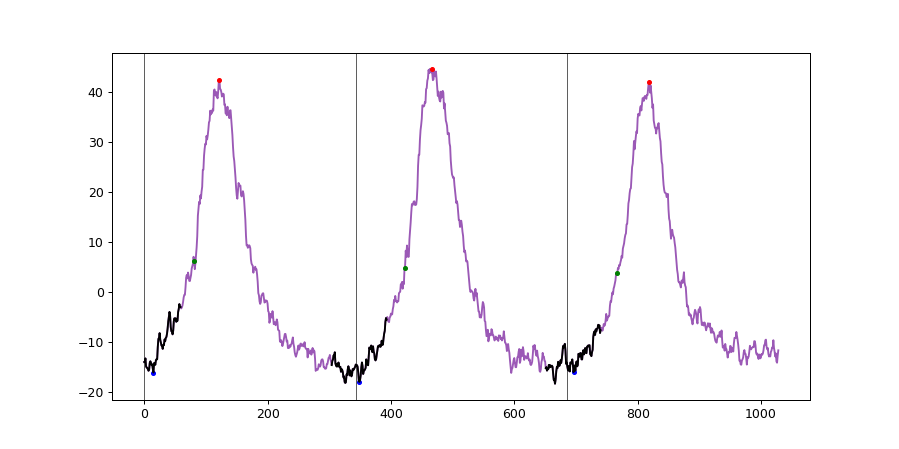

In [446]:


fig, ax = pl.subplots(figsize=(10,5)) #pl.figure()

ax.plot(avg_cycle_c1)
for cyc in parsed_cycle_ixs[c1][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)
    
for cmax in cmaxima:
    ax.plot(cmax[0], cmax[1], 'r.')
    
for cmin in cminima:
#     print cmin
#     if not cmin[0].size:
#         continue
    ax.plot(cmin[0], cmin[1], 'b.')
    
for ons in onsets:
    if not ons[0].size:
        continue
    ax.plot(ons[0], ons[1], 'g.')
    
for bi, bv in zip(baseline_indices, baseline_values):
    ax.plot(bi, bv, 'k')

# Get bar positions from MW

In [448]:
import pymworks
from pipeline.python.paradigm import process_mw_files as mw

In [447]:
mwfile = glob.glob(os.path.join(run_dir, 'raw*', 'paradigm_files', '*.mwk'))[0]
df = pymworks.open(mwfile)
mw.

'/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/raw_4a63f9/paradigm_files/20190215_JC047_FOV1_retino_f2.mwk'

In [290]:
1029/3.


343.0

In [297]:
1029-686.

343.0

In [298]:
fr_per_cyc

1029

In [299]:
stiminfo[curr_cond]['n_frames_per_cycle'] 

343